## Tweets EDA + Data cleaning
Exploratory data analysis about the extracted tweets containing the hashtag #SDGs in english.
In the process, tweet duplicates and more will be cleaned to build the final dataset to be fed for individual SDG classification.

In [ ]:
import pandas as pd
import csv
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
#nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/marty/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

### About the dataset:
The dataset contains the complete archive of tweets in english from 1/9/2015 to 1/3/2022 that contain the #SDGs hashtag with the following attributes: 'twid','authid','created_at','lang','like_count','quote_count','reply_count','retweet_count','text'.
For further details of the implementation you can refer to the `Archive tweet collector.ipynb` file. Due to various errors with connection and to avoid spamming the twitter API the data was collected in 5 different stages stated below, which were merged (refer to `merge_data.ipynb`) into a unique file `tweetsSDG_enALL.cvs`.\

On the other hand, `NoRelevant_enALL.cvs` contains tweets that do not have tag related to the SDGs. And has been collected merging many queries using a tool from twitter. (More info on `No SDG archive merger.ipynb`).\

Finally, in order to further mine the tweets containing individual SDG tags and using the same prior twitter tool, a dataset of tweets tagged as #SDG+(1-17) but not #SDG has been collected for completeness. This dataset (`SDGn_NOT#SDGs_en.csv`) shall be merged latter on with the main dataset to be fed to the ML module later on.

Date split record dataset:
* tweetsSDG_en1.csv: 
    * from 2022-03-01 00:00:00+00:00
    * to 2021-03-16 11:20:43+00:00
* tweetsSDG_en2.csv: 
    * from 2021-03-16 11:20:43+00:00
    * to 2020-11-27 13:39:51+00:00
* tweetsSDG_en3.csv:
    * from 2020-11-27 13:39:51+00:00 
    * to 2018-09-25 12:00:01+00:00
* tweetsSDG_en4.csv:
    * from 2018-09-25 12:00:01+00:00 
    * to 2018-08-10 12:18:23+00:00
* tweetsSDG_en5.csv:
    * from 2018-08-10 12:18:23+00:00 
    * to 2015-09-01 00:00:45+00:00
* tweetsSDG_enALL.csv:
    * merged file of all splits.

In [ ]:
# This might take a while (10s max)
# The C engine rise errors for a large file, hence the specifications
df = pd.read_csv('tweetsSDG_enALL.csv', engine='python',
                 usecols=['twid','authid','created_at','text'])
display(df.head())

,twid,authid,created_at,text
0,6.385017e+17,2.657144e+09,2015-09-01 00:00:45+00:00,From @UGECProject: #urban #SDGs difficult bc u...
1,6.385022e+17,5.979171e+08,2015-09-01 00:02:51+00:00,Internet Speech: Is It Free or Not? http://t.c...
2,6.385023e+17,2.657144e+09,2015-09-01 00:03:03+00:00,Applied research needed to test #SDGs in citie...
3,6.385025e+17,3.448317e+08,2015-09-01 00:03:57+00:00,"RT @ TriplePundit: For SABMiller, the #SDGs ar..."
4,6.385026e+17,1.578572e+09,2015-09-01 00:04:06+00:00,Thanks @irishmissionun for co-facilitating #SD...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487456 entries, 0 to 1487455
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   twid        1482079 non-null  float64
 1   authid      1482079 non-null  float64
 2   created_at  1482079 non-null  object 
 3   text        1482079 non-null  object 
dtypes: float64(2), object(2)
memory usage: 45.4+ MB


### Repair reading and writing issues:
Although in the merging process of the dataset records were checked to not be null and Tweet ids to be unique it seems that either the reading or writing process for such a large file introduces null records and might compromise the uniqueness of tweet ids. We will take this chance to remove twid (tweet id) duplicates, text duplicates and bot-written tweets as well.

In [ ]:
# Drop rows that don't contain information
df.dropna(inplace=True)

In [ ]:
# parse to right types for each column
df['twid'] = df['twid'].astype('int')
df['authid'] = df['authid'].astype('int')
df['created_at'] = pd.to_datetime(df['created_at'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482079 entries, 0 to 1487455
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype              
---  ------      --------------    -----              
 0   twid        1482079 non-null  int64              
 1   authid      1482079 non-null  int64              
 2   created_at  1482079 non-null  datetime64[ns, UTC]
 3   text        1482079 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(2), object(1)
memory usage: 56.5+ MB


In [ ]:
print('Number of duplicated tweet ids:')
print(len(df[df['twid'].duplicated()]))
print('Number of duplicated text:')
print(len(df[df['text'].duplicated()]))

Number of duplicated tweet ids:
28
Number of duplicated text:
87944


In [ ]:
# Check id duplicates:
display(df[df['twid'].duplicated()].head())
display(df[df['twid']==693085715790479360])
display(df[df['twid']==703508008798658560])
print("\n".join(df[df['twid']==693085715790479360]['text'].to_list()))
print("\n".join(df[df['twid']==703508008798658560]['text'].to_list()))

,twid,authid,created_at,text
26155,646638062085251072,482128456,2015-09-23 10:51:42+00:00,@BabatundeUNFPA\nGovernments must show respons...
86670,673786453000921088,493933600,2015-12-07 08:49:43+00:00,Tony Elumelu stresses the importance of the #S...
105711,693085715790479360,632859279,2016-01-29 14:58:06+00:00,@APRMorg will be more relevant when linked to ...
107668,694664545135116288,423888869,2016-02-02 23:31:48+00:00,@SDGaction @rtgp137 @StephanieMbida Not the pr...
117707,703508008798658560,3979106777,2016-02-27 09:12:34+00:00,Goodmorning! It's #SDGsSaturday. Dont's forget...


,twid,authid,created_at,text
105707,693085715790479360,2725876718,2016-01-29 14:58:06+00:00,@APRMorg will be more relevant when linked to ...
105711,693085715790479360,632859279,2016-01-29 14:58:06+00:00,@APRMorg will be more relevant when linked to ...


,twid,authid,created_at,text
117705,703508008798658560,4588966817,2016-02-27 09:12:34+00:00,Goodmorning! It's #SDGsSaturday. Dont's forget...
117707,703508008798658560,3979106777,2016-02-27 09:12:34+00:00,Goodmorning! It's #SDGsSaturday. Dont's forget...


@APRMorg will be more relevant when linked to @_AfricanUnion Agenda 2063 and #SDGs Agenda 2030. ~ @UKenyatta https://t.co/NMmVIrbfX4
@APRMorg will be more relevant when linked to @_AfricanUnion Agenda 2063 and #SDGs Agenda 2030. ~ @UKenyatta https://t.co/yrlyTQ5aab
Goodmorning! It's #SDGsSaturday. Dont's forget to share your weekly progress on the #SDGs using the hashtag #SDGsSaturday
Goodmorning! It's #SDGsSaturday. Dont's forget to share your weekly progress on the #SDGs using the hashtag #SDGsSaturday


**Conclusion:** Judging by the examples that we see, the id duplicates do not only cooincide in twid, but in every other aspect of the tweet except the authorID. Hence, it is likely a duplicate collection of the same tweet. Therefore, we can remove them safely without fearing of losing information from the dataset.

,twid,authid,created_at,text
5,638503522829475840,269061236,2015-09-01 00:07:57+00:00,Thanks @irishmissionun for co-facilitating #SD...
7,638504388739383296,20492991,2015-09-01 00:11:23+00:00,Thanks @irishmissionun for co-facilitating #SD...
8,638504390366785536,960717428,2015-09-01 00:11:24+00:00,Thanks @irishmissionun for co-facilitating #SD...
9,638504678154629120,2252700961,2015-09-01 00:12:32+00:00,Thanks @irishmissionun for co-facilitating #SD...
10,638505703011954688,3388301277,2015-09-01 00:16:37+00:00,Thanks @irishmissionun for co-facilitating #SD...


Thanks @irishmissionun for co-facilitating #SDGs. @Irish_Aid @CharlieFlanagan join us at the #GlobalCitizen Festival &amp; commit to #endpoverty
Thanks @irishmissionun for co-facilitating #SDGs. @Irish_Aid @CharlieFlanagan join us at the #GlobalCitizen Festival &amp; commit to #endpoverty

Value counts for duplicated text:



,count
We call on world leaders at #UNGA to help children outside of families by ensuring #AllChildrenCount in the #SDGs. #Hopeland,9691
Thanks @irishmissionun for co-facilitating #SDGs. @Irish_Aid @CharlieFlanagan join us at the #GlobalCitizen Festival &amp; commit to #endpoverty,8779
"Thank you @KanoStateGovt, @aksgovt, and @BornoGovt for your work thus far on the #SDGs. Please join Global Citizen in 2020 and commit between USD $14-21 million to help end open defecation for the citizens you represent. 💧 🇳🇬 🚽",6172
Congrats #Guterres from #GlobalCitizens on being named #nextsg. Lets make #SDGs a reality by 2030 and end extreme poverty once and for all.,1874
The #PrivateSector is best positioned to drive forward progress toward the #SDGs. Thank you @BofA_News for encouraging this important #WEF20 convo.,1838


array([9691, 8779, 6172, 1874, 1838, 1118, 1117, 1117, 1116, 1073,  918,
        509,  502,  393,  352,  344,  199,  197,  191,  164,  147,  138,
        126,  114,  108,  107,  104,  102,  102,   91,   88,   87,   83,
         82,   79,   79,   78,   78,   77,   76,   75,   74,   73,   73,
         70,   69,   68,   65,   64,   63])

Index(['We call on world leaders at #UNGA to help children outside of families by ensuring #AllChildrenCount in the #SDGs. #Hopeland',
       'Thanks @irishmissionun for co-facilitating #SDGs. @Irish_Aid @CharlieFlanagan join us at the #GlobalCitizen Festival &amp; commit to #endpoverty',
       'Thank you @KanoStateGovt, @aksgovt, and @BornoGovt for your work thus far on the #SDGs. Please join Global Citizen in 2020 and commit between USD $14-21 million to help end open defecation for the citizens you represent. 💧 🇳🇬 🚽',
       'Congrats #Guterres from #GlobalCitizens on being named #nextsg. Lets make #SDGs a reality by 2030 and end extreme poverty once and for all.',
       'The #PrivateSector is best positioned to drive forward progress toward the #SDGs. Thank you @BofA_News for encouraging this important #WEF20 convo.',
       'Only those who risk going too far can possibly find out how far they can go.#psychology #health #houston  #philanthropy #noew2017 #sdgs',
       'You get fr

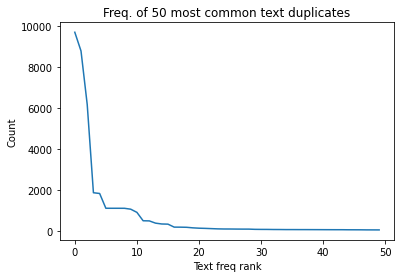

,created_at_min,created_at_max,count,time_d
text,,,,
We call on world leaders at #UNGA to help children outside of families by ensuring #AllChildrenCount in the #SDGs. #Hopeland,2016-09-19 14:07:16+00:00,2018-07-12 21:03:54+00:00,9691,661 days 06:56:38
Thanks @irishmissionun for co-facilitating #SDGs. @Irish_Aid @CharlieFlanagan join us at the #GlobalCitizen Festival &amp; commit to #endpoverty,2015-09-01 00:07:57+00:00,2015-09-25 23:57:54+00:00,8779,24 days 23:49:57
"Thank you @KanoStateGovt, @aksgovt, and @BornoGovt for your work thus far on the #SDGs. Please join Global Citizen in 2020 and commit between USD $14-21 million to help end open defecation for the citizens you represent. 💧 🇳🇬 🚽",2019-09-26 13:39:26+00:00,2021-07-06 00:48:27+00:00,6172,648 days 11:09:01
Congrats #Guterres from #GlobalCitizens on being named #nextsg. Lets make #SDGs a reality by 2030 and end extreme poverty once and for all.,2016-10-06 16:48:53+00:00,2017-02-28 16:55:46+00:00,1874,145 days 00:06:53
The #PrivateSector is best positioned to drive forward progress toward the #SDGs. Thank you @BofA_News for encouraging this important #WEF20 convo.,2020-01-23 21:26:27+00:00,2020-03-30 12:15:19+00:00,1838,66 days 14:48:52
Only those who risk going too far can possibly find out how far they can go.#psychology #health #houston #philanthropy #noew2017 #sdgs,2017-03-25 08:14:17+00:00,2020-04-27 08:14:55+00:00,1118,1129 days 00:00:38
You get from the world what you give to the world.#mindfulness #wellness #psychology #health #houston #philanthropy #noew2017 #sdgs #csr,2017-03-26 03:40:25+00:00,2020-04-27 03:41:32+00:00,1117,1128 days 00:01:07
"Your abilities can take you to the top, but it is your character that will keep you there.#houston #noew2017 #sdgs #csr #mentalhealth",2017-03-25 18:28:59+00:00,2020-04-26 18:28:57+00:00,1117,1127 days 23:59:58
For it is in giving that we receive. #noew2017 #sdgs #csr #houston #texas #mentalhealth #mindfulness #wellness #psychology #health,2017-03-26 15:52:56+00:00,2020-04-27 15:53:18+00:00,1116,1128 days 00:00:22


In [ ]:
# Check text duplicates:
display(df[df['text'].duplicated()].head())

print("\n".join(df[df['twid']==638503522829475840]['text'].to_list()))
print("\n".join(df[df['twid']==638504388739383296]['text'].to_list()))

# Check how many different duplicated texts exist and its count:
print('\nValue counts for duplicated text:\n')
value_counts = df[df['text'].duplicated()]['text'].value_counts().to_frame()
value_counts.rename(columns={'text':'count'}, inplace=True)
display(value_counts.head())
display(value_counts['count'].head(50).values)
print(value_counts.head(10).index)

plt.plot(value_counts.head(50).values)
plt.title('Freq. of 50 most common text duplicates')
plt.ylabel('Count')
plt.xlabel('Text freq rank')
plt.show()

# Join would have been enough if suffixes were specified
text_dupl = df[df['text'].duplicated()][['text','created_at']].groupby(['text']).min().merge(
    df[df['text'].duplicated()][['text','created_at']].groupby(['text']).max(),
    left_on='text', right_on='text', suffixes=('_min', '_max')) 

text_dupl = text_dupl.join(value_counts).sort_values(by='count', ascending=False)
text_dupl['time_d'] = text_dupl['created_at_max']-text_dupl['created_at_min'] 
display(text_dupl.head(10))

**Conclusion:** There is definitely some tweets that seem to be written by bots considering the similarity of the tags and message. It is even more obvious in the case of very high frequency. However, it is hard to determine the bot nature by time delta. Examining publishing patterns with more complex analysis looks promising. For our case, we will delete all duplicates for simplicity's sake.

#### Remove duplicates
Although there are not full row duplicates, it is in our best interest to remove rows that have identical text and or tweet id, since our final goal is to train a model and we want to have an heterogeneous training set. Therefore, we will need to remove bot-written tweets later on.

In [ ]:
df.drop_duplicates(subset=['twid'], inplace=True)
df.drop_duplicates(subset=['text'], inplace=True) # Note: we might be removing some bot messages here already
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1394121 entries, 0 to 1487455
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype              
---  ------      --------------    -----              
 0   twid        1394121 non-null  int64              
 1   authid      1394121 non-null  int64              
 2   created_at  1394121 non-null  datetime64[ns, UTC]
 3   text        1394121 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(2), object(1)
memory usage: 53.2+ MB
None


#### Dive deeper on removing bots
Note: This section is not prioritary and will be implemented if deemed specialy relevant further on.
Aproach: Remove taggs and account citations, then compare again for texts with identical or highly similar text ordering.

## Explore percentace of individual tagged tweets:
Find and classify percentage of tweets that contain one or more individual SDG tags (ex: #SDG9)\
**Note:** Since the collection of individually tagged tweets was done in two stages, we need to merge both datasets once individually tagged tweets are filtered from the original dataset

In [ ]:
# Filter tweets that contain possible individual SDGn tags
# Reduce dataframe to improve performance
dfTag = df[['twid','text']][df['text'].str.contains(r'\#SDG(\d{1,2})')]
display(dfTag.head())
dfTag.info()

/home/marty/.local/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,twid,text
271,638601322569310208,@CSBAGUGANDA @FOWODE_UGANDA linking the globa...
797,638727916881334272,.@Empower_Women Agree it's abt #SDG17: #ICT &a...
859,638732576283336704,Who agrees w/ me? #Goal2 makes much #SocioEcon...
3664,639385607895019520,#SDG2 wants to end hunger by 2030. A challenge...
3948,639455106556166144,"The #SDGs must aim for progress for everyone, ..."


<class 'pandas.core.frame.DataFrame'>
Int64Index: 65895 entries, 271 to 1487353
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   twid    65895 non-null  int64 
 1   text    65895 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [ ]:
# Merge with the second dataset of individual SDGn tweets
dfTag2 = pd.read_csv('./Raw data/SDGn_NOT#SDGs_en.csv', usecols=['id','text'])
display(dfTag2.head())
dfTag2.info()

,id,text
0,1498444874655633408,Surely @WHO can do better? Thankfully we have ...
1,1498443208388272132,#SDG14 How true is this! #UONTeach and #EDUC47...
2,1498439228249632768,Wanna change the world? Join ONE and the fight...
3,1498436690951606273,Join us for the next instalment of our 'Water ...
4,1498434111714824199,Tribune: Two-thirds of households in Punjab la...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643441 entries, 0 to 643440
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      643441 non-null  int64 
 1   text    643441 non-null  object
dtypes: int64(1), object(1)
memory usage: 9.8+ MB


In [ ]:
# Concatenate both datasets
dfTag.rename(columns={'twid':'id'}, inplace=True) # rename to match column names
dfTagAll = pd.concat([dfTag, dfTag2])
dfTagAll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709336 entries, 271 to 643440
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      709336 non-null  int64 
 1   text    709336 non-null  object
dtypes: int64(1), object(1)
memory usage: 16.2+ MB


In [ ]:
# Check and drop duplicates
# if queries where correct, there should be no overlap
print('Duplicated ids for the merged individual SDG dataset:')
print(len(dfTagAll[dfTagAll['id'].duplicated()]))

dfTagAll.drop_duplicates(subset=['id'], inplace=True)

# The overlap is insignificant and probably caused by the collection process

Duplicated ids for the merged individual SDG dataset:
500


In [ ]:
# Check and drop text duplicates (needs to be done again since we merged with a new dataset)
print('Duplicated text in tweets:')
print(len(dfTagAll[dfTagAll['text'].duplicated()]))

dfTagAll.drop_duplicates(subset=['text'], inplace=True)

Duplicated text in tweets:
75155


The number of duplicated tweets is left for the record, but they were actually substracted.

In [ ]:
# quick visualization:
dfTagAll.reset_index(inplace=True)
display(dfTagAll.head())

,index,id,text
0,271,638601322569310208,@CSBAGUGANDA @FOWODE_UGANDA linking the globa...
1,797,638727916881334272,.@Empower_Women Agree it's abt #SDG17: #ICT &a...
2,859,638732576283336704,Who agrees w/ me? #Goal2 makes much #SocioEcon...
3,3664,639385607895019520,#SDG2 wants to end hunger by 2030. A challenge...
4,3948,639455106556166144,"The #SDGs must aim for progress for everyone, ..."


In [ ]:
# Extract the concrete individual tags (this may take a while)
def lambda_condition(x):
    arr = x.dropna().astype(int).unique()
    return [val for val in arr if (val<18 and val>0)]

dfTagAll['tags']=dfTagAll['text'].str.extractall(r'\#SDG(\d{1,2})').unstack().apply(lambda x: lambda_condition(x), axis=1)
display(dfTagAll.head(3))

,index,id,text,tags
0,271,638601322569310208,@CSBAGUGANDA @FOWODE_UGANDA linking the globa...,[3]
1,797,638727916881334272,.@Empower_Women Agree it's abt #SDG17: #ICT &a...,[17]
2,859,638732576283336704,Who agrees w/ me? #Goal2 makes much #SocioEcon...,[2]


In [ ]:
# create an atribute containing the number of valid SDG tags and remove the rows that contain 0 valid SDG tags
# with those meeting the regex query AND meeting the condition 1-17 bein valid.
dfTagAll.dropna(inplace=True)
dfTagAll.drop(columns=['index'], inplace=True)
dfTagAll['#tags'] = dfTagAll['tags'].apply(lambda x: len(x))
dfTagAll = dfTagAll[dfTagAll['#tags'] != 0]

In [ ]:
display(dfTagAll[dfTagAll['#tags']>9].head())

,id,text,tags,#tags
10213,930928397550628864,#COP23 Side Events Spotlight Climate Action Ch...,"[2, 6, 8, 9, 11, 13, 14, 15, 16, 17]",10
13900,964200185588011008,UN Women Presents Actionable Recommendations t...,"[5, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14...",17
14867,970225350956417024,The future for Kenya’s wildlife depends on wha...,"[1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13]",11
16744,983800032846467072,Social Justice Ireland Reports on Ireland's SD...,"[2, 3, 4, 5, 6, 7, 10, 12, 13, 14, 15, 17]",12
16986,985925926469996544,SDG Knowledge Weekly: Blockchain in Practice\n...,"[1, 2, 5, 6, 7, 12, 13, 14, 15, 16, 17]",11


In [ ]:
# Percentages
print("Percentage of tweets with '#SDGs' that contain valid individual #: ", len(dfTag)/len(df)*100, '%')
print("Percentage of tweets that contain more than one individual tag: ", len(dfTag[dfTag['#tags']>1])/len(dfTag)*100, '%')

print('Amount of individual tag frequency in a single tweet: ')
display(pd.DataFrame(data={'tweet_count':dfTagAll['#tags'].value_counts(sort=True, ascending=True),
                   'frequency':dfTagAll['#tags'].value_counts(normalize=True)}))

Percentage of tweets with '#SDGs' that contain valid individual #:  4.555989042557998 %
Percentage of tweets that contain more than one individual tag:  15.026135147049564 %
Amount of individual tag frequency in a single tweet: 


,tweet_count,frequency
1,508597,0.896246
2,43775,0.077140
3,10195,0.017966
4,2749,0.004844
5,1144,0.002016
6,566,0.000997
7,231,0.000407
8,87,0.000153
9,47,0.000083
10,20,0.000035


The table above describes the amount tweets containing a certan number of individual SDG tags. For example, we can read that an 85% of the tweets that contain an individual SDG tag only contain that tag.

In [ ]:
# Build dictionary: tweet id to list of individual SDG contained
indSDG2counts = {}
for SDGnum in range(1, 18):
    indSDG2counts[SDGnum] = len(dfTagAll[dfTagAll.apply(lambda x: SDGnum in x['tags'], axis=1)])
print(indSDG2counts)

{1: 16904, 2: 32890, 3: 52446, 4: 86223, 5: 74359, 6: 57430, 7: 65017, 8: 19820, 9: 10757, 10: 14380, 11: 26247, 12: 20776, 13: 47198, 14: 38495, 15: 15251, 16: 48044, 17: 24461}


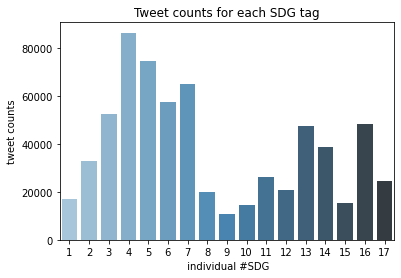

In [ ]:
ax = sns.barplot(x=list(indSDG2counts.keys()), y=list(indSDG2counts.values()), palette='Blues_d')
ax.set(xlabel=' individual #SDG', ylabel='tweet counts', title='Tweet counts for each SDG tag');

## Prepare datasets for classification
In this section we will prepare labeled and clean dataset 1, dataset 2 is cleaned in a separate module:
1. Dataset for relevant SDG tweet classification (binary)
2. Dataset for individual SDG classification (multiclass)

#### General useful functions:

In [ ]:
# Tweet text preleaning
def tweet_preCleaning(tweet):
    # replace endlines with spaces
    tweet = tweet.replace('\n',' ')
    
    # Remove media links and undisired characters
    return re.sub(r"(@[A-Za-z0–9_]+)|#|http\S+|sdgs?|&\w+|[^\w\s]", '', tweet)

def stopword_removal(tweet):
    return [w for w in tweet if w not in stopwords.words('english')]

def tweet_lemmatizing (tweet): # input: list of tokenized words from a tweet
    lemmatizer = WordNetLemmatizer() # lemmatizer instantiation
    return [lemmatizer.lemmatize(word) for word in tweet]

In [ ]:
# Create a column to process text for safety
dfTagAll['cleanText'] = dfTagAll['text']

In [ ]:
# Removing html (media in twitter is converted into links too), removing endlines and unescaping html entities
dfTagAll['cleanText'] = dfTagAll['cleanText'].apply(lambda x: tweet_preCleaning(x))
display(dfTagAll['cleanText'].head())

0       linking the global development framework SD...
1     Agree its abt SDG17 ICT  innovation as means ...
2    Who agrees w me Goal2 makes much SocioEconomic...
3    SDG2 wants to end hunger by 2030 A challenge f...
4    The SDGs must aim for progress for everyone ev...
Name: cleanText, dtype: object

In [ ]:
# Tokenization, remove stopwords and punctuation (This may take a while)

# text is lowered, then tokenized and stopwords are removed
dfTagAll['cleanText'] = dfTagAll['cleanText'].apply(lambda x: word_tokenize(x.lower()))
print('Done with tokenizing')
dfTagAll['cleanText'] = dfTagAll['cleanText'].apply(lambda x: stopword_removal(x))
print('Done with stopword removal')
display(dfTagAll['cleanText'].head())

Done with tokenizing
Done with stopword removal


0    [linking, global, development, framework, sdgs...
1    [agree, abt, sdg17, ict, innovation, means, im...
2    [agrees, w, goal2, makes, much, socioeconomic,...
3    [sdg2, wants, end, hunger, 2030, challenge, as...
4    [sdgs, must, aim, progress, everyone, everywhe...
Name: cleanText, dtype: object

In [ ]:
# Lemmatizing

dfTagAll['cleanText'] = dfTagAll['cleanText'].apply(lambda x: tweet_lemmatizing(x))
display(dfTagAll['cleanText'].head())

0    [linking, global, development, framework, sdgs...
1    [agree, abt, sdg17, ict, innovation, mean, imp...
2    [agrees, w, goal2, make, much, socioeconomic, ...
3    [sdg2, want, end, hunger, 2030, challenge, asi...
4    [sdgs, must, aim, progress, everyone, everywhe...
Name: cleanText, dtype: object

##### Store the Cleaned tweets for later ML tasks
Note: cleaned text still contains the labels remaining from the sdg tags, therefore should be removed before training

In [ ]:
display(dfTagAll.head())
dfTagAll.info()

,id,text,tags,#tags,cleanText
0,638601322569310208,@CSBAGUGANDA @FOWODE_UGANDA linking the globa...,[3],1,"[linking, global, development, framework, sdgs..."
1,638727916881334272,.@Empower_Women Agree it's abt #SDG17: #ICT &a...,[17],1,"[agree, abt, sdg17, ict, innovation, mean, imp..."
2,638732576283336704,Who agrees w/ me? #Goal2 makes much #SocioEcon...,[2],1,"[agrees, w, goal2, make, much, socioeconomic, ..."
3,639385607895019520,#SDG2 wants to end hunger by 2030. A challenge...,[2],1,"[sdg2, want, end, hunger, 2030, challenge, asi..."
4,639455106556166144,"The #SDGs must aim for progress for everyone, ...",[3],1,"[sdgs, must, aim, progress, everyone, everywhe..."


<class 'pandas.core.frame.DataFrame'>
Int64Index: 567475 entries, 0 to 633680
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         567475 non-null  int64 
 1   text       567475 non-null  object
 2   tags       567475 non-null  object
 3   #tags      567475 non-null  int64 
 4   cleanText  567475 non-null  object
dtypes: int64(2), object(3)
memory usage: 26.0+ MB


In [ ]:
dfTagAll.to_csv('engTagClassDataset.csv', index=False)